# Kalman Filters

In [19]:
import numpy as np
from scipy import signal
from numpy.random import randn
import matplotlib.pyplot as plt
import filterpy as fp
import filterpy.stats as stats
from kf_book import book_plots as book_plots

Kalman filters are a method of filtering noisy data.
The noise is usually associated with sensor noise.

The math involved, whilst not extremely difficult, can sometimes be ove my head.<br>
Especially when we move into multivariate examples

However the basic principle is quite intuitive!

1. take two measurements, or a measurement and a prediction
2. choose the output to be somewhere between the two. 

If you believe the measurement more your guess will be closer to the measurement; <br>
If you believe the prediction is more accurate your guess will be clsoer to the prediction

The clever part is that the measurement and prediction can be modelled with Gaussians

A Gaussian can be thought of as a probibility distribution, which has a mean and a variance.<br>
We will use named tuples to model our Gaussians

In [2]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

In [3]:
z1 = gaussian(3, 2)
print(z1)

𝒩(μ=3.000, 𝜎²=2.000)


In [4]:
z2 = gaussian(8, 0.5)

In [5]:
x1 = np.arange(0, 10, 0.1)
y1 = [stats.gaussian(x, z1.mean, z1.var) for x in x1]
x2 = np.arange(0, 10, 0.1)
y2 = [stats.gaussian(x, z2.mean, z2.var) for x in x2]

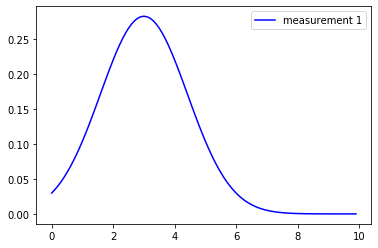

In [6]:
plt.plot(x1, y1, 'b', label = 'measurement 1')
plt.legend()

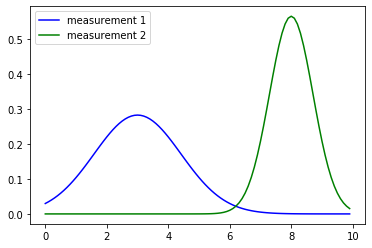

In [7]:
plt.plot(x1, y1, 'b', label = 'measurement 1')
plt.plot(x2, y2, 'g', label = 'measurement 2')
plt.legend()

According to Dr Kalman, given the right conditions, the product of 2 Gaussians is another Gaussian:

$$\begin{aligned}
\mu &= \frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$

In [8]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

In [9]:
z_prod = gaussian_multiply(z1, z2)
x3 = np.arange(0,10,0.1)
y3 = [stats.gaussian(x, z_prod.mean, z_prod.var) for x in x3]

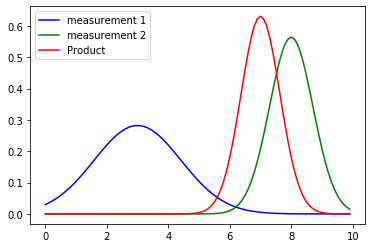

In [10]:

plt.plot(x1, y1, 'b', label = 'measurement 1')
plt.plot(x2, y2, 'g', label = 'measurement 2')
plt.plot(x3, y3, 'r-', label = 'Product')
plt.legend()


Lets see another example

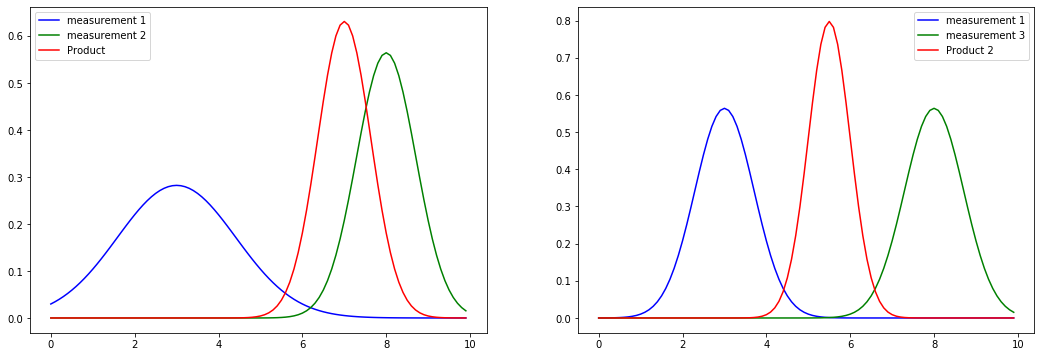

In [13]:
z1a = gaussian(3, 0.5)
x1a = np.arange(0, 10, 0.1)
y1a = [stats.gaussian(x, z1a.mean, z1a.var) for x in x1a]

z_prod_2 = gaussian_multiply(z1a, z2)
x4 = np.arange(0,10,0.1)
y4 = [stats.gaussian(x, z_prod_2.mean, z_prod_2.var) for x in x4]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
ax1.plot(x1, y1, 'b', label = 'measurement 1')
ax1.plot(x2, y2, 'g', label = 'measurement 2')
ax1.plot(x3, y3, 'r-', label = 'Product')
ax1.legend()
ax2.plot(x1a, y1a, 'b', label = 'measurement 1')
ax2.plot(x2, y2, 'g', label = 'measurement 3')
ax2.plot(x4, y4, 'r-', label = 'Product 2')
ax2.legend()

That's really cool - but how does it help us implement a filter.<br>
For that, we need to think about the actual Kalman Algorithm

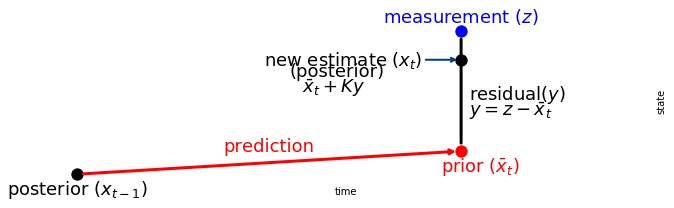

In [59]:
import kf_book.book_plots as book_plots
book_plots.show_residual_chart()

## Some Terminology
The <b>Posterior</b> is the current know state of the system <br>
The <b>Prior</b> is the <b>Predicted</b> state of the system, before we take a measurement <br>
The <b>Measurement</b> is the measurement <br>
<br>
And as we saw, when we combine 2 pieces of information, the result is somewhere in between. <br>
This is our new <b>Posterior</b>

Now we need a coupe of helper functions to make predictions and updates

In [15]:
def update(prior, measurement):
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
    
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance
    return gaussian(x, P)

def predict(posterior, movement):
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q
    return gaussian(x, P)

def volt(voltage, std):
    return voltage + (randn() * std)

Text(0, 0.5, 'Voltage')

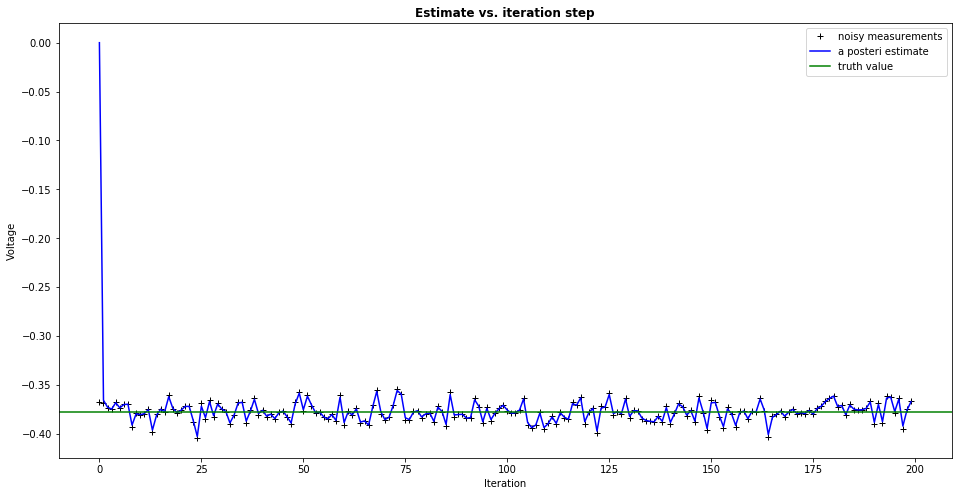

In [43]:

# A Python implementation of the example given in pages 11-15 of "An
# Introduction to the Kalman Filter" by Greg Welch and Gary Bishop,
# University of North Carolina at Chapel Hill, Department of Computer
# Science, TR 95-041,
# https://www.cs.unc.edu/~welch/media/pdf/kalman_intro.pdf

# by Andrew D. Straw

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 8)

# intial parameters
n_iter = 200
sz = (n_iter,) # size of array
x = -0.37727 # truth value (typo in example at top of p. 13 calls this z)
z = np.random.normal(x,0.01,size=sz) # observations (normal about x, sigma=0.1)

Q = 1e-5 # process variance
Q = 1e-1

# allocate space for arrays
xhat=np.zeros(sz)      # a posteri estimate of x
P=np.zeros(sz)         # a posteri error estimate
xhatminus=np.zeros(sz) # a priori estimate of x
Pminus=np.zeros(sz)    # a priori error estimate
K=np.zeros(sz)         # gain or blending factor

R = 0.1**2 # estimate of measurement variance, change to see effect

# intial guesses
xhat[0] = 0.0
P[0] = 1.0

for k in range(1,n_iter):
    # time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1]+Q

    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]

plt.figure()
plt.plot(z,'k+',label='noisy measurements')
plt.plot(xhat,'b-',label='a posteri estimate')
plt.axhline(x,color='g',label='truth value')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Voltage')

# plt.figure()
# valid_iter = range(1,n_iter) # Pminus not valid at step 0
# plt.plot(valid_iter,Pminus[valid_iter],label='a priori error estimate')
# plt.title('Estimated $\it{\mathbf{a \ priori}}$ error vs. iteration step', fontweight='bold')
# plt.xlabel('Iteration')
# plt.ylabel('$(Voltage)^2$')
# plt.setp(plt.gca(),'ylim',[0,.01])
# plt.show()
